# Implementing T-SNE via Tensorflow

The technique known as T-distributed Stochastic Neighbor Embedding (or T-SNE for short) is a fairly common method of dimensional reduction employed that is design to keep the separation between sets of points in a larger space equivalent when modeled in a lower-dimensional space.

It does this by calculating two distances, one in the high-dimensional space and another in a low-dimensional space, which are then used in order to minimize the Kullback-Leibler distance between both distributions. This should be fairly straightforward using TensorFlow as the gradients should be taken care of for the most part, and most functions seem to have built-in operations in place already.

In its original usage, points are initially randomly initialized and then gradients are taken in order to improve the initial estimates of the lower-dimensional points. However, this application leaves much to be desired when considering out-of-dataset information. The second application, known as parametric T-SNE, is far less commonly used and instead uses a neural network as a means of mapping the larger dimensional space to the lower dimensional space. Optimizations then take place on the weights intrinsic to the network instead of immediately on the lower-dimensional points. It is quite unstable depending on the initialization of the network, and that's perhaps one of its shortcomings.

## Basic T-SNE Implementation

Usually, it's easier to start with symmetric SNE and work our way towards an asymettrical approach afterward, but because TensorFlow deals with most of the work with the gradient, there's no reason to not start with the non-symmetric approach first nowadays.

To start, let's set up the probabilistic interpretation of the likelihood that, given some input sample $i$ in high-dimensional space (assumed to be distributed as a gaussian), $j$ is the closest neighbor:

$$ p_{j|i} = \frac{\text{exp}\left(-\lVert x_i - x_j \rVert^2\right / 2\sigma^2_i)}{\sum_{k\ne i}\text{exp}\left(-\lVert x_i - x_k \rVert^2\right / 2\sigma^2_i)} $$

Similarly, we calculate a similarity score in the lower-dimensional space (this time assuming it follows a Student t-Distribution):

$$ q_{ij} = \frac{\left(1+\lVert y_i - y_j \rVert^2\right)^{-1}}{\sum_{k\ne l}\left(1+\lVert y_k - y_l\rVert^2\right)^{-1}} $$

In general, however, we would like to set up a properly symmetric $p_{ij}$ that is not as susceptible to outliers in space. In order to do so, we can construct a symmetric matrix by performing the following averaging:

$$ p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n} $$

Finally, we can measure the discrepancy between these two distributions by calculating the Kullback-Leibler divergence between the two distributions:

$$ D_{\text{KL}}\left(P||Q\right) = \sum_{i\ne j} p_{ij} \log\ \frac{p_{ij}}{q_{ij}}$$

Clearly, if we are trying to make these two distributions similar, we are minimizing the KL function. In other words, our optimal solution is the following:

$$ y^* = \arg\min_{y_i} D_{\text{KL}}\left(P||Q\right)$$

Because only $Q$ is a function of $y$, this is actually fairly simple to optimize, but as this is a TensorFlow optimization, that is not necessary to cover here.

### On Choosing a Proper $\sigma_i$

One thing to keep in mind is that even though the above seems straightforward, these is one hyperparameter that wasn't discussed here. The choice of $\sigma_i$ was not discussed and must actually be determined for each row of the matrix, $P_i$. 

Perplexity can be described as the expected number of neighbors that a given sample is expected to have, but in practice it functions more as a softmax softening element (much like temperature in the knowledge distillation case.) The authors of the original paper suggested that the perplexity be chosen as some integer between 5-50, but in practice it is suggested that it scale with $\sqrt{N}$ for larger datasets. The math is a bit suspect when it comes to the proof for the suggestion, but just remember that we can calculate the perplexity of a given row $P_i$ as follows:

$$ Per(P_i) = \sum_j p_{j|i}\log_2 p_{j|i} $$

As evident from the temperature case, this function is monotonically increasing with respect to $\sigma_i$, and thus we can use a binary search to identify our proper $\sigma_i$'s for proper use. 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

In [ ]:
# Given a tensor representing a sample's similarity probability scores,
# returns the perplexity of that tensor. Note that the perplexity for this
# application is only controllable by the variance of the sample
# Note that the mask tells us the valid elements to sum to calculate the
# entropy as 0*log(0) is undefined.
@tf.function
def perp(probTensor, mask):
    pTensor = tf.where(tf.cast(mask, tf.bool), 
                       probTensor*tf.experimental.numpy.log2(probTensor),
                       tf.zeros_like(probTensor, dtype=tf.float64))
    return tf.pow(tf.constant(2.0, dtype = tf.float64), -1 * tf.reduce_sum(pTensor))

# We need a modified softmax as we want to normalize with respect to the row EXCLUDING
# those elements on the diagonal. We can do this by isolating the diagonal as a column
# vector and removing those values
@tf.function
def ignoreDiagSoftmax(inputLogits):
    midMat = tf.exp(inputLogits)
    return midMat / (tf.reduce_sum(midMat, axis = 1, keepdims=True) - tf.reshape(tf.linalg.diag_part(midMat), shape=[-1,1]))

# Computes the softmax of a given inputLogits under the assumption that the only desired values
# are those contained within the mask.
@tf.function
def maskedSoftmax(inputLogits, mask):
    midMat = tf.exp(inputLogits)
    return midMat / tf.reduce_sum(midMat * mask)

# Given a functor that takes in a single argument (a float value between curLB and curHB),
# return the optimal value given a testFunctor. Since our GPU will be evaluating this,
# an interative solution is used. Note that the functor must naturally be
# monotonically _increasing_ for this function.
def binarySearch(functorToTest, target, curLB, curRB, tolerance = 1e-4):
    # we can avoid improper tracing by instantiating loop vars out here
    mid = (curLB + curRB) / 2
    valToCompare = functorToTest(mid)

    while (curLB < curRB) and (abs(target - valToCompare) > tolerance):
        if valToCompare < target:
            # current value too low
            curLB = mid
        else:
            # current value too high
            curRB = mid

        mid = (curLB + curRB) / 2
        valToCompare = functorToTest(mid)

    return mid

# This generates a distance array given an NxM input where the N rows represent
# samples and the M columns represent the number of features
# (This is used in tf as well, but we generate the concrete functor later)
def generateSquaredDistMat(features):
    r = tf.reduce_sum(features**2, 1)
    r = tf.reshape(r, [-1, 1])
    return r - 2*tf.matmul(features, features, transpose_b=True) + tf.transpose(r)  # matmul with T arg much faster

# This only calculates the || x_i - x_j || rows. This is useful for calculating
# sigmas at a later step when included with the images
def eyeWrapperPLFunc(numElems):
    preppedEyeMask = 1.0-tf.eye(numElems, dtype = tf.float64)

    def generatePseudoLogits(images, labels):
        dists = generateSquaredDistMat(images)
        return (dists, preppedEyeMask), labels

    return generatePseudoLogits

# This functor helps us go row-by-row to find the optimal sigma values
def sigmaPerpFactory(perplexity):
    specPerp = tf.constant(perplexity, dtype=tf.float64)

    def findOptimalSigma(distDS, label):
        distRow, mask = distDS
        relSearchFunc = lambda sigma : perp(maskedSoftmax((-1 * distRow) / (2 * sigma**2), mask), mask)
        sigma = binarySearch(relSearchFunc, specPerp, tf.constant(1.0, dtype=tf.float64), tf.constant(10000, dtype=tf.float64))

        return (distRow, sigma), label

    return findOptimalSigma

# With a proper column tensor of sigmas, we can properly wrap the entire dataset once again
# to generate the proper values
def numElemWrapper(numElems):
    diagZeroMatrix = tf.zeros(shape=(numElems,), dtype=tf.float64)

    def wrapFinalProbs(distsDS, labels):
        distsArr, sigmas = distsDS
        pijCond = ignoreDiagSoftmax((-1.0 * distsArr) / (2 * sigmas ** 2))

        # We would also like to set the conditionals on the diagonal to 0
        pijCond = tf.linalg.set_diag(pijCond, diagZeroMatrix)

        # now with our conditional array, we can generate the final tensors
        # by normalizing across columns
        pijFinal = (pijCond + tf.transpose(pijCond)) / (2*numElems)

        return pijFinal, labels

    return wrapFinalProbs

In [ ]:
# We can import the MNIST dataset for use here (but we will focus mainly on the 0's, 1's, and 9's
# to avoid the visual clutter)
(trainDS,), dsInfo = tfds.load('mnist', split=['test'], shuffle_files=False,
                            as_supervised=True,
                            with_info=True)

# Performs class filtering and formats images as normalized rows
desiredClasses = tf.constant([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=tf.int64)
@tf.function
def filterFunc(image, label):
    return tf.math.reduce_any(desiredClasses == label)

trainDS = trainDS.filter(filterFunc).map(lambda image, label: (tf.reshape(tf.cast(image, dtype = tf.float64), shape=[-1]), label))

# Unfortunately, we don't know the number of samples we have taken so we need them now
numElems = 0
for _ in trainDS:
    numElems += 1
print("Dataset has been loaded with {} elems.".format(numElems))

Dataset has been loaded with 10000 elems.


In [ ]:
## These are the user settable parameters
LEARNING_RATE = .5 # Determines the step size for the optimizer
NUM_PCA_DIMS = 40   # Number of dimensions to keep when applying the PCA transformation onto the dataset
PERPLEXITY = 50  # This is a "measure" of possibly how many similar neighbors a single sample could have
MAX_ITERS = 1000    # This algorithm should converge fairly quickly if properly optimized
L_DIM_SIZE = 2      # How many dimensions we want in the low-dim space (obv should be less than input dims)

In [ ]:
# Generate a batch to pass onto sklearn
PCABatch = trainDS.batch(numElems)
for batch in PCABatch.take(1):
    toExamine, origLabels = batch

# Generate the transformation
decomp = PCA(n_components = NUM_PCA_DIMS)
newDat = decomp.fit_transform(toExamine)

# Repackage into new dataset
trainDS = tf.data.Dataset.from_tensor_slices((newDat, origLabels))

In [ ]:
# We now must calculate the appropriate values for sigma for each given sample
# We start by batching the entire dataset and performing conversion into probabilistic
# arrays as an entire batch
testDS = trainDS.batch(numElems).map(eyeWrapperPLFunc(numElems)).unbatch().map(sigmaPerpFactory(PERPLEXITY), num_parallel_calls = tf.data.AUTOTUNE).batch(numElems).map(numElemWrapper(numElems)).cache()

The above set up all of our required values for the high-dimensional space. Now all we need to do is initialize our values in low-dimensional space and begin attempting to optimize the problem!

Like before, we set up are initial matrix and some helper functions to convert our low-dimensional points into another probability matrix. We can then iterate this process until we get an appropriate graph representing the T-SNE plot!

In [ ]:
# Prepare function for calculating affinity in lower dims
# This gets called frequently, so let's convert it into a proper tf.func as well
@tf.function
def generateTStudentAffinity(lowDimFeatures):
    # Generate our squared distances
    dists = generateSquaredDistMat(lowDimFeatures)

    # Calculate the numerator and normalize it with respect to entire matrix
    preNorm = 1.0/(1.0 + dists)
    return preNorm / (tf.reduce_sum(preNorm) - tf.linalg.trace(preNorm))

# The same as above but without the normalization. This helps prevent the 
# repetition of a calculation.
@tf.function
def generateUnNormedTStudentAffinity(lowDimFeatures):
    # simply return inversed square distances
    return 1.0 / (1.0 + generateSquaredDistMat(lowDimFeatures))

# Takes in the old low-dimensional features and returns the new set of them
# based on the analytical derivative on the paper. This is useful when the
# dataset gets too large and causes the gradients to become smaller than 
# what can be held in typical 32b FP tensors.
@tf.function
def calculateGradient(lowDimFeatures, PMat):
    # Calculate our unnormed Q matrix for use
    UNQMat = generateUnNormedTStudentAffinity(lowDimFeatures)

    # Calculate our N x N constant matrix C
    C = 4.0 * (PMat - (UNQMat / (tf.reduce_sum(UNQMat) - tf.linalg.trace(UNQMat)))) * UNQMat

    # Generate N X N X L_DIM potential update matrix
    toUpdateTensor = tf.reshape(lowDimFeatures, shape=[numElems, 1, L_DIM_SIZE]) - tf.reshape(lowDimFeatures, shape = [1, numElems, L_DIM_SIZE])

    # Finally, calculate the delta update matrix for return
    deltas = tf.reduce_sum(tf.expand_dims(C, -1) * toUpdateTensor, axis=1)

    # We return the updates for the optimizer to apply them
    return deltas

def batchLossWrapper(batchSize):
    def loss_func(PMat, QMat):
        klMat = tf.multiply(PMat, tf.math.log(PMat + 1e-8) - tf.math.log(QMat + 1e-8))
        toset = tf.constant(0, shape=[batchSize], dtype=klMat.dtype)
        klMat = tf.linalg.set_diag(klMat, toset)

        return tf.reduce_sum(klMat)
    return loss_func

# We can also go ahead and initialize our optimizer and loss function here
lossFunc = batchLossWrapper(numElems)
opt = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

In [ ]:
# We can make a function that plots our points and simply clear the plot. Note that
# our original dataset contains all the data points' labels on which we would like
# to plot with, so we use that to selectively grab rows and plot each value
# separately.
class DoublePlotter():
    def __init__(self, originalDSLabels, relLabels, softAlpha = 0.2, initFeats = None):
        # prepare plot (this output can't be eaten so decorate this with a capture)
        self.fig, self.ax = plt.subplots(1, 1, figsize = (15,15), dpi = 70)

        # generate boolean indexing arrs
        self.idxArr = [originalDSLabels == curLab for curLab in relLabels]

        # Now set up our plotting functors
        def plotAlphaWrapper(alpha = 1.0):
            def plotElems(inFeats):
                # plot all relevant plots in different colors
                for curVal, curBoolArr in enumerate(self.idxArr):
                    self.ax.plot(inFeats[curBoolArr,0], inFeats[curBoolArr,1], 'o', markersize=2, alpha=alpha)
            return plotElems

        # And some necessary functors for later
        self.clrFunc = lambda : self.ax.cla()
        self.plotSoft = plotAlphaWrapper(softAlpha)
        self.plotHard = plotAlphaWrapper()

        # And a history is necessary to keep track of old plots
        self.hist = initFeats.copy() if initFeats is not None else None

    def plotNextValue(self, newFeats):
        #   1) Erase the plot
        #   2) Plot the old values using plotSoft
        #   3) Plot the new values using plotHard
        self.clrFunc()
        self.ax.set_prop_cycle(None)
        self.plotSoft(self.hist) if self.hist is not None else None
        self.ax.set_prop_cycle(None)
        self.plotHard(newFeats)

        # Update the hist
        self.hist = newFeats.copy()

        # And show the plot
        return self.fig

    def __call__(self, arg):
        return self.plotNextValue(arg)

    def getPlot(self):
        return self.fig

    def getAxes(self):
        return self.ax

In [ ]:
# Initialize our lower-dimensional space
lowDimFeats = tf.Variable(tf.random.normal(shape = (numElems, L_DIM_SIZE), mean = 0.0, stddev = tf.math.sqrt(tf.cast(1e-4, dtype=tf.float64)), dtype=tf.float64), dtype=tf.float64)

In [ ]:
%%capture
# # We need the labels so we query them now from the prepared dataset
# # (We only have one batch so we have no need for the dataset intrinsic params)
for dsElem in testDS:
    highDimProbs, labels = dsElem
labels = labels.numpy()

# Prepare our plotting object for the optimization
curPlotObj = DoublePlotter(labels, list(desiredClasses.numpy()))

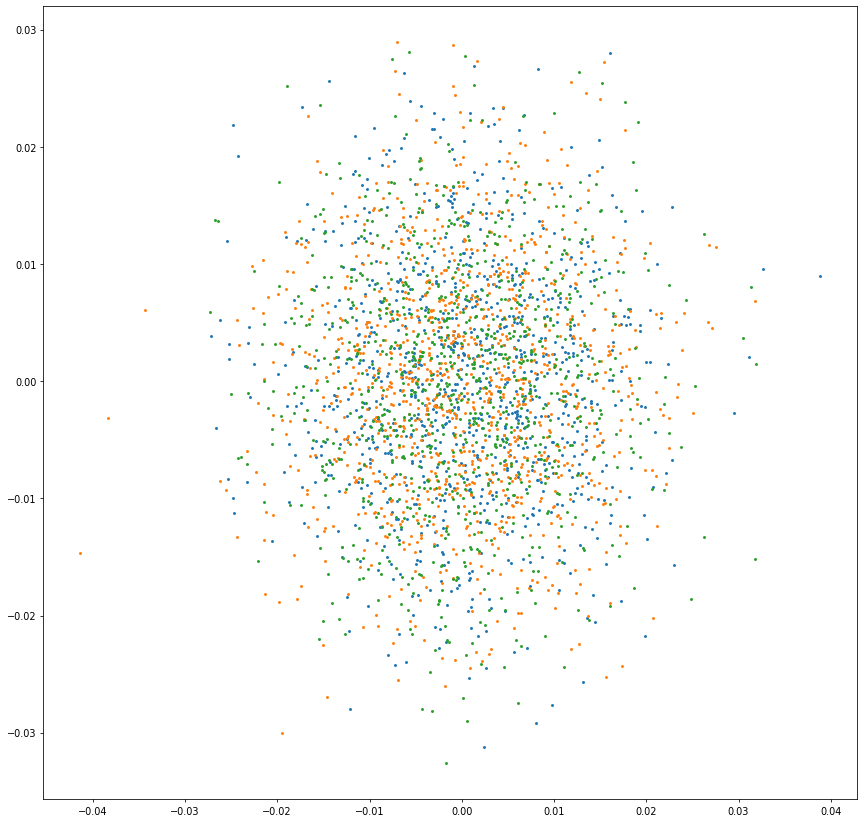

In [ ]:
# View our initialized plot
curPlotObj(lowDimFeats.numpy())

  0%|          | 0/1000 [00:00<?, ?it/s]

 Loss : 0.00034325

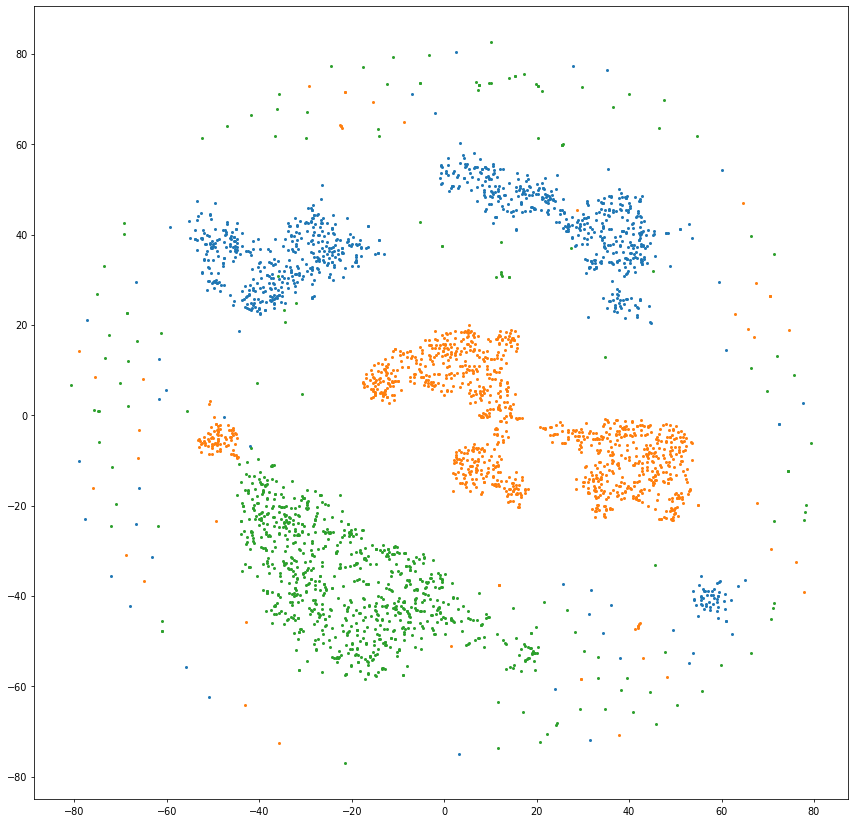

In [ ]:
# Proceed with optimization
# Yes, there is no masking being performed to ignore the diagonals. As it so happens
# to turn out, the gradient is indifferent to these values as the analytical gradient
# does not contain the values of the KL divergence anywhere.
for curIter in tqdm(range(MAX_ITERS)):
    with tf.GradientTape() as tape:
        # Add our input to optimization graph
        tape.watch(lowDimFeats)

        # Perform a forward pass of algorithm
        curLowDimProbs = generateTStudentAffinity(lowDimFeats)

        # Calculate Losses
        totalLoss = lossFunc(highDimProbs, curLowDimProbs)

    # Print our loss for the iteration
    print("\r Loss : {:0.8f}".format(totalLoss.numpy()), end = '')

    # Now backpropagate and optimize
    grads = tape.gradient(totalLoss, lowDimFeats)
    opt.apply_gradients(zip([grads], [lowDimFeats]))

# Use our last position as final point
curPlotObj(lowDimFeats.numpy())
curPlotObj(lowDimFeats.numpy())

One thing to note is that there always seems to be a sort of "halo" of noisy points surrounding the clusters. I'm not quite sure why these appear but it does seem to be intrinsic to the way that the gradient tape calculates the gradients as there doesn't seem to be any in the following example...

Of course the gradient has been derived analytically in the paper and can be used freely as follows:

$$ \frac{\delta C}{\delta y_i} = 4\sum_{j} (p_{ij}-q_{ij})(y_i-y_j)\left(1+||y_i-y_j||^2\right)^{-1}$$

The right-most term is pre-calculated in our un-normalized $q_{ij}$'s row values (but this needs some un-normalization). When summed this represents a constant. The left-most term is clearly a constant as well and the only value that determines the overall direction of the derivative is the middle term that finds the difference between two points in the lower-dimensional space. So we can think of the derivative as trying to minimize the changes where the difference between the original and new similarities are similar and increase it where it is needed. In other words, examples are either pushed or attracted to a given sample depending on the relative separation that exists in their high-dimensional space.

The following is vectorized and seems to perform decently enough on a 10000 x 10000 matrix full of double floats. Of course, the implicit trade-off associated with this is that we can no longer calculate the same values on a much larger dataset. To do so, we would need to split up the updates into batches instead...

In [ ]:
# Re-initialize for analytical usage
lowDimFeats = tf.Variable(tf.random.normal(shape = (numElems, L_DIM_SIZE), mean = 0.0, stddev = tf.math.sqrt(tf.cast(1e-4, dtype=tf.float64)), dtype=tf.float64), dtype=tf.float64)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Loss : 0.00032367

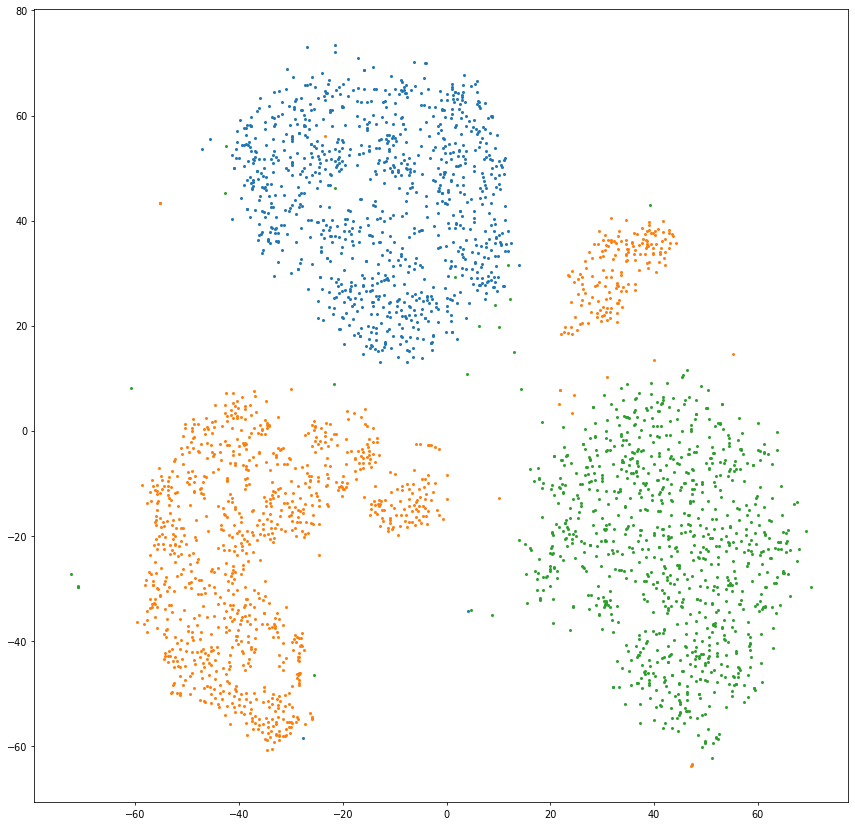

In [ ]:
# This implements the analytical gradient and doesn't use TF's build in
# gradient tape. This takes less memory as it doesn't require the implicit
# cloning of a bunch of gradients to gradually assemble the whole thing.
for curIter in tqdm(range(MAX_ITERS)):
    # Calculate gradients for current instantiation
    grads = calculateGradient(lowDimFeats, highDimProbs)

    # Apply gradients using optimizer
    opt.apply_gradients(zip([grads], [lowDimFeats]))

    # Print loss
    print("\r Loss : {:0.8f}".format(lossFunc(highDimProbs, generateTStudentAffinity(lowDimFeats)).numpy()), end = '')

# Use last potition as final point
curPlotObj(lowDimFeats.numpy())
curPlotObj(lowDimFeats.numpy())

### Improvements

The paper covers two techniques to generate more "satisfying" plots. They give some explanations for them as follows:

* __Early Exaggeration__
    * This can be implemented by multiplying our target probabilities by some constant value, $E_V$ for the first $M$ iterations. This helps allow our initial probabilities to cluster around a bit more aggressively and exaggerate the distances between the clusters (to make them more evident) later on.
* __Early Compression__
    * In this scenario, we add a slight penalty to the squared distances of the values for the lower-dimensional representations. By doing so, we can allow the optimized values to more easily move between clusters while they are still close. This is just a contribution to the loss function and can use the built-in parameters in tensorflow.

We make slight alterations to the non-tensorflow gradient version as follows... $ $

#### Early Compression

In [ ]:
# Re-initialize for analytical usage
lowDimFeats = tf.Variable(tf.random.normal(shape = (numElems, L_DIM_SIZE), mean = 0.0, stddev = tf.math.sqrt(tf.cast(1e-4, dtype=tf.float64)), dtype=tf.float64), dtype=tf.float64)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Loss : 0.86900928

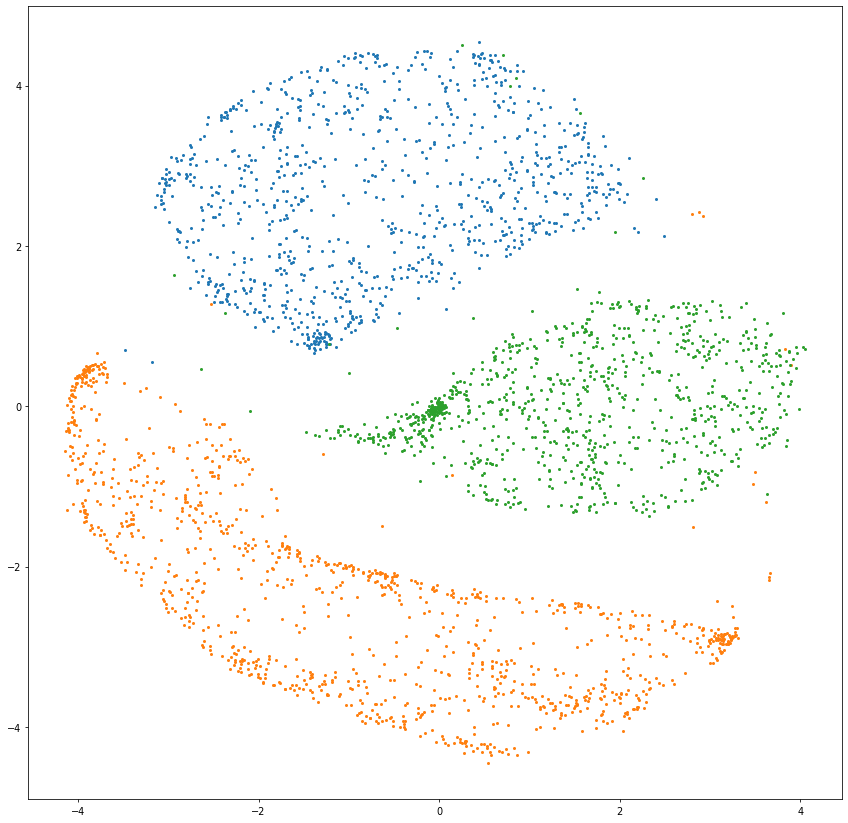

In [ ]:
# HYPERPARAMETERS FOR EARLY COMPRESSION
EC_WEIGHT = 0.0001

@tf.function
def calculateL2Penalty(lowDimFeatures):
    return EC_WEIGHT * tf.reduce_sum(tf.norm(lowDimFeatures, axis=1))

# This implements the analytical gradient and doesn't use TF's build in
# gradient tape. This takes less memory as it doesn't require the implicit
# cloning of a bunch of gradients to gradually assemble the whole thing.
for curIter in tqdm(range(MAX_ITERS)):
    # Calculate gradients for current instantiation
    grads = calculateGradient(lowDimFeats, highDimProbs)

    # Use gradienttape to calculate our norm contribution to grad
    with tf.GradientTape() as tape:
        tape.watch(lowDimFeats)
        penalty = calculateL2Penalty(lowDimFeats)

    # Apply gradients using optimizer
    penaltyGrads = tape.gradient(penalty, lowDimFeats)
    opt.apply_gradients(zip([grads + penaltyGrads], [lowDimFeats]))

    # Print loss
    print("\r Loss : {:0.8f}".format(lossFunc(highDimProbs, generateTStudentAffinity(lowDimFeats)).numpy() + penalty.numpy()), end = '')

# Use last potition as final point
curPlotObj(lowDimFeats.numpy())
curPlotObj(lowDimFeats.numpy())

#### Early Exaggeration

In [ ]:
# Re-initialize for analytical usage
lowDimFeats = tf.Variable(tf.random.normal(shape = (numElems, L_DIM_SIZE), mean = 0.0, stddev = tf.math.sqrt(tf.cast(1e-4, dtype=tf.float64)), dtype=tf.float64), dtype=tf.float64)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Loss : 0.00033142

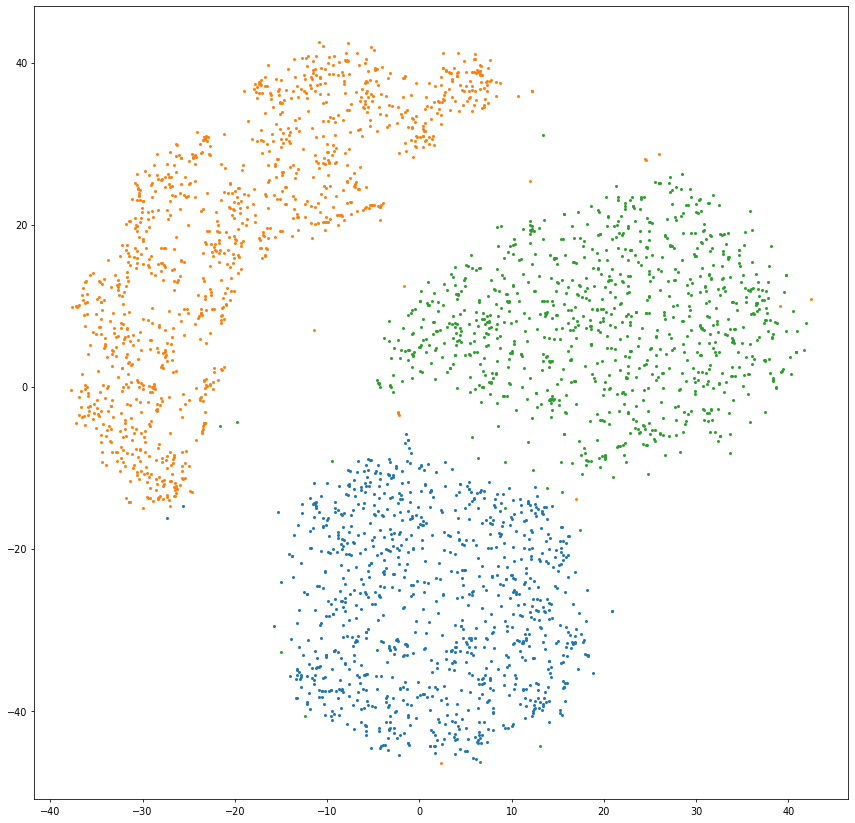

In [ ]:
# HYPERPARAMETERS FOR EARLY EXAGGERATION
EE_VALUE = 4.0
EE_DURATION = 50

# Don't touch these values. They will form the "profile" for the iterative process
exaggerationValues = [EE_VALUE if iterNum < EE_DURATION else 1.0 for iterNum in range(MAX_ITERS)]
for curIter in tqdm(range(MAX_ITERS)):
    # Calculate gradients for current instantiation
    grads = calculateGradient(lowDimFeats, exaggerationValues[curIter] * highDimProbs)

    # Apply gradients using optimizer
    opt.apply_gradients(zip([grads], [lowDimFeats]))

    # Print loss
    print("\r Loss : {:0.8f}".format(lossFunc(highDimProbs, generateTStudentAffinity(lowDimFeats)).numpy()), end = '')

# Use last potition as final point
curPlotObj(lowDimFeats.numpy())
curPlotObj(lowDimFeats.numpy())

As stated in the original paper, the purposes of either are, in the final product, quite similar in their usage. Although it should be quite clear that due to the naturally large variational pushes from the gradient of the KL divergence, the latter is usually far easier to finetune due to being able to pass integer values.

What follows is the above implemented on a much larger subset of the MNIST dataset. This time it's implemented on all 10 classes of unspecified sample count.

## Final Implementation with 10k MNIST Dataset

In [ ]:
# Re-initialize for analytical usage
lowDimFeats = tf.Variable(tf.random.normal(shape = (numElems, L_DIM_SIZE), mean = 0.0, stddev = tf.math.sqrt(tf.cast(1e-4, dtype=tf.float64)), dtype=tf.float64), dtype=tf.float64)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Loss : 0.000121

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f68508fa890> has a label of '_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f68508fa5d0> has a label of '_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f685092f290> has a label of '_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f685092f350> has a label of '_' which cannot be automatically added to the legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f68509c6210> has a label of '_' w

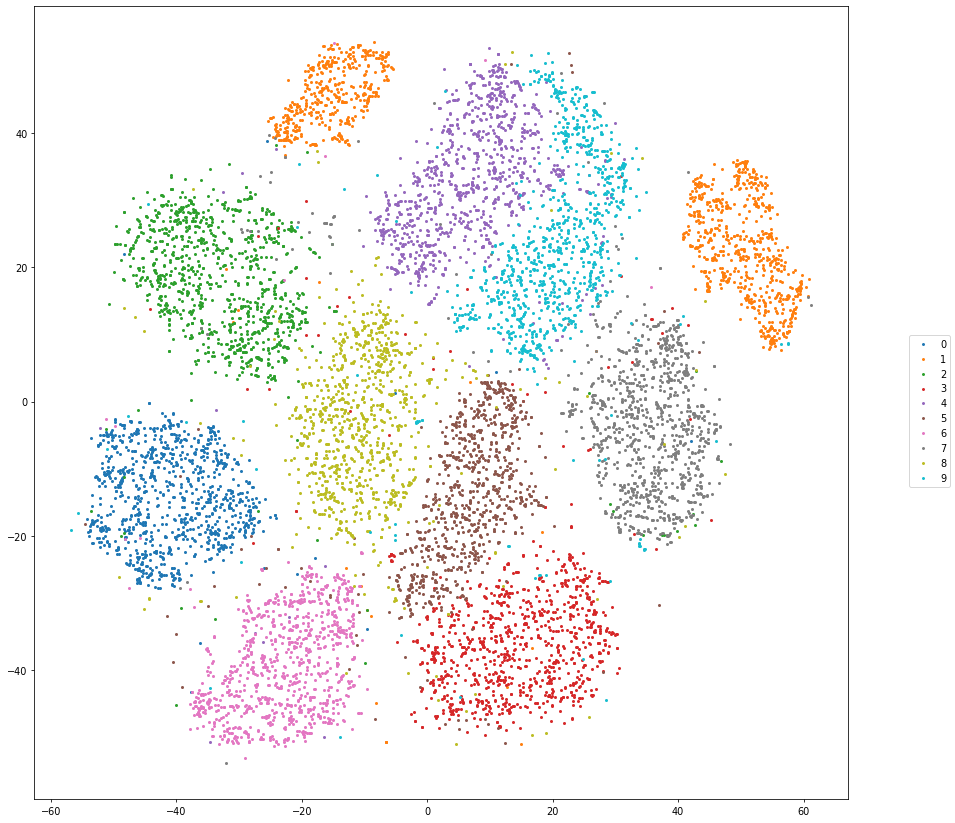

In [ ]:
# HYPERPARAMETERS FOR EARLY EXAGGERATION
EE_VALUE = 4.0
EE_DURATION = 50

# Don't touch these values. They will form the "profile" for the iterative process
exaggerationValues = [EE_VALUE if iterNum < EE_DURATION else 1.0 for iterNum in range(MAX_ITERS)]
for curIter in tqdm(range(MAX_ITERS)):
    # Calculate gradients for current instantiation
    grads = calculateGradient(lowDimFeats, exaggerationValues[curIter] * highDimProbs)

    # Apply gradients using optimizer
    opt.apply_gradients(zip([grads], [lowDimFeats]))

    # Print loss
    print("\r Loss : {:f}".format(lossFunc(highDimProbs, generateTStudentAffinity(lowDimFeats)).numpy()), end = '')

# Use last potition as final point
curPlotObj(lowDimFeats.numpy())
curPlotObj(lowDimFeats.numpy())
curPlotObj.getPlot().legend(["_" for _ in range(10)] + ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], loc = 'center right')
curPlotObj.getPlot()

# Parametric T-SNE

One thing to keep in mind is that for all the steps above, we optimized directly on the low-dimensional space. This can be fine in applications where our dataset is small enough to have all the values pre-computed and stored into an $O(N^2)$ matrix. However, there are many situations in which this is either intractible or impossible due to a dataset that can constantly acquire new examples. In order to take care of these types of situations, we now describe a more applicable algorithm: parametric T-SNE.

Why parametric? The answer is actually quite simple. Before, we immediately iterated on low-dimensional points. However, in this new application, we instead initialize some function $f(x)$, that represents some mapping from a high-dimensional space to a low-dimensional space. In that way, instead of optimizing on our low-dimensional $y$'s, we will instead be optimizing on the weights of the network. That way, our problem now becomes:

$$ W^* = \arg\min_{W} D_{\text{KL}}\left(P||Q\right) $$

where

$$P$$ remains the same as explained above, and ...

$$ q_{ij} = \frac{\left(1+\lVert f(x_i;W) - f(x_j;W) \rVert^2\right)^{-1}}{\sum_{k\ne l}\left(1+\lVert f(x_k;W) - f(x_l;W)\rVert^2\right)^{-1}} $$

With this, $f(x)$ becomes our low-level projector of high-level features and can be used to create new points in our projected view when necessary.

Simple enough, right? One might notice that the dataset size issues might still prop up here as well. In practice, we simply apply the gradient descent onto a mini-batch of the dataset. While this mistakenly assumes that any point is almost as equally likely to be a neighbor, it's the only practical way that a neural network would be processing the number of points available in large datasets.

With some knowledge of algorithms, we can theoretically create a pseudo-representation of these clusters using a graph representation with random walks and NN probabilities or something closer to an estimate using something like a k-d graph, but it's significantly more effort than necessary.

## Initial Encoder / Decoder Training

In the paper, the authors used a stacked RBM network in order to act as the encoder for the data. They used a typical RBM training scheme with distributions chosen to ensur the model output something between 0-1 near the final layers, but that isn't strictly necessary. A CNN will be used for testing later, but for now let's just approach it in a similar way the authors did in the paper.

RBMs are fine for estimating certain types of distributions, but they aren't exactly necessary as almost any distribution an RBM is designed to estimate can technically be estimated by at least a two-layer network. In the end, the authors chose it due to an RBM better representing the probabalistic nature of the optimization scheme, but we won't bother with it and simply train a neural network with layer activations equivalent to the distribution choices made for the network on the paper. Keep in mind that while they were forced to drop the biases, doing so doesn't seem to make too big of a difference for this parametric version (but you can see the results at the bottom for proof of that).

In [ ]:
# Restart kernel to get a fresh start for this section
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

In [ ]:
# We built a simple encoder in this section. We use a simple res-net like architecture
# for MNIST. It doesn't have to be quite large considering the small input image
# size.
LATENT_DIM_SIZE = 2

# This is the original network used in the paper
def paperNetwork(input_shape, output_dim):
    inLayer = tf.keras.Input(shape = input_shape)

    # Flatten to use in network
    output = tf.keras.layers.Flatten()(inLayer)

    # Then apply the dense layers
    output = tf.keras.layers.Dense(500, activation='sigmoid')(output)
    output = tf.keras.layers.Dense(500, activation='sigmoid')(output)
    output = tf.keras.layers.Dense(2000, activation='sigmoid')(output)
    output = tf.keras.layers.Dense(output_dim, activation='linear')(output)

    return tf.keras.Model(inLayer, output)

In [ ]:
# We can load in MNIST now like before
trainDS, = tfds.load('mnist', split=['train'], shuffle_files=True,
                            as_supervised=True,
                            with_info=False)

trainDS = trainDS.map(lambda image, label: (tf.reshape(tf.cast(image, dtype = tf.float64)/255., [-1]), label))

# Unfortunately, we don't know the number of samples we have taken so we need them now
numElems = int(tf.data.experimental.cardinality(trainDS).numpy())
print("Dataset has been loaded with {} elems.".format(numElems))

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Dataset has been loaded with 60000 elems.


In [ ]:
# And define our helper funcs like before. These could be included in the class
# as static functions but leaving them out is convenient for now.
@tf.function
def perp(probTensor, mask):
    pTensor = tf.where(tf.cast(mask, tf.bool), 
                       probTensor*tf.experimental.numpy.log2(probTensor),
                       tf.zeros_like(probTensor, dtype=tf.float64))
    return tf.pow(tf.constant(2.0, dtype = tf.float64), -1 * tf.reduce_sum(pTensor))

@tf.function
def ignoreDiagSoftmax(inputLogits):
    midMat = tf.exp(inputLogits)
    return midMat / (tf.reduce_sum(midMat, axis = 1, keepdims=True) - tf.reshape(tf.linalg.diag_part(midMat), shape=[-1,1]))

@tf.function
def maskedSoftmax(inputLogits, mask):
    midMat = tf.exp(inputLogits)
    return midMat / tf.reduce_sum(midMat * mask)

def binarySearch(functorToTest, target, curLB, curRB, tolerance = 1e-4):
    # we can avoid improper tracing by instantiating loop vars out here
    mid = (curLB + curRB) / 2
    valToCompare = functorToTest(mid)

    while (curLB < curRB) and (abs(target - valToCompare) > tolerance):
        if valToCompare < target:
            # current value too low
            curLB = mid
        else:
            # current value too high
            curRB = mid

        mid = (curLB + curRB) / 2
        valToCompare = functorToTest(mid)

    return mid

def generateSquaredDistMat(features):
    r = tf.reduce_sum(features**2, 1)
    r = tf.reshape(r, [-1, 1])
    return r - 2*tf.matmul(features, features, transpose_b=True) + tf.transpose(r)  # matmul with T arg much faster

def eyeWrapperPLFunc(numElems):
    preppedEyeMask = 1.0-tf.eye(numElems, dtype = tf.float64)

    def generatePseudoLogits(images, labels):
        dists = generateSquaredDistMat(images)
        return (dists, preppedEyeMask), labels

    return generatePseudoLogits

def numElemWrapper(numElems):
    diagZeroMatrix = tf.zeros(shape=(numElems,), dtype=tf.float64)

    def wrapFinalProbs(distsDS, labels):
        distsArr, sigmas = distsDS
        pijCond = ignoreDiagSoftmax((-1.0 * distsArr) / (2 * sigmas ** 2))

        # We would also like to set the conditionals on the diagonal to 0
        pijCond = tf.linalg.set_diag(pijCond, diagZeroMatrix)

        # now with our conditional array, we can generate the final tensors
        # by normalizing across columns
        pijFinal = (pijCond + tf.transpose(pijCond)) / (2*numElems)

        return pijFinal, labels

    return wrapFinalProbs

def sigmaPerpFactory(perplexity):
    specPerp = tf.constant(perplexity, dtype=tf.float64)

    def findOptimalSigma(distDS, label):
        distRow, mask = distDS
        relSearchFunc = lambda sigma : perp(maskedSoftmax((-1 * distRow) / (2 * sigma**2), mask), mask)
        sigma = binarySearch(relSearchFunc, specPerp, tf.constant(1.0, dtype=tf.float64), tf.constant(10000, dtype=tf.float64))

        return (distRow, sigma), label

    return findOptimalSigma

In [ ]:
# Class TSNEModel
#   Inputs: A Keras Model wrapper for T-SNE embeddings creation
#   Outputs: Produces a fully wrapped model that allows fit() usage with a 
#            preprocessed dataset.
class TSNEModel(tf.keras.Model):
    def __init__(self, embeddingsModel, exaggerationValue = 4.0, exaggerationDuration = 0, l2Penalty = 0.01,
                 l2PenaltyDuration = 0, batch_size = 1024, pretrainNetwork = True):
        super(TSNEModel, self).__init__(inputs = embeddingsModel.inputs, outputs = embeddingsModel.outputs)
        self.innerModel = embeddingsModel
        self.lossTracker = tf.keras.metrics.Mean(name='loss')
        self.batch_size = batch_size
        self.exaggerationValue = tf.Variable(exaggerationValue, trainable=False, dtype=tf.float64)
        self.l2PenaltyVal = tf.Variable(l2Penalty, trainable=False, dtype=tf.float32)
        self.pretrainFlag = pretrainNetwork
        self.infDS = False
        self.dsElemCnt = None
        self.weightsToTrain = self.innerModel.trainable_weights

        # We build an internal class here to set as a callback for exaggeration
        # values
        class VarWatcherCallback(tf.keras.callbacks.Callback):
            def __init__(self, varToWatch, defaultVal, duration, dtype = tf.float64):
                super(VarWatcherCallback, self).__init__()
                self.desiredDuration = duration # swaps back once countdown completes
                self.originalVal = tf.constant(defaultVal, dtype=dtype)
                self.varToWatch = varToWatch

            def on_train_batch_begin(self, batch, logs = None):
                if self.desiredDuration == 0: #upon finishing last iter with var
                    self.varToWatch.assign(self.originalVal)
                elif self.desiredDuration > 0:
                    self.desiredDuration -= 1

        # And associate callback with the model
        exaggCallback = VarWatcherCallback(self.exaggerationValue, 1.0, exaggerationDuration)
        penaltyCallback = VarWatcherCallback(self.l2PenaltyVal, 0.0, l2PenaltyDuration, self.l2PenaltyVal.dtype)
        self.tsneCallbacks = [exaggCallback, penaltyCallback]

    ''' 
        We only allow ourselves to customize the optimizer as all other values
        are handled internally. This function is naturally restrictive as there
        is no purpose in allowing custom loss functions.
    '''
    def compile(self, opt):
        super(TSNEModel, self).compile()
        self.opt = opt
        self.loss = TSNEModel.loss_func

    '''
        Overwrites the fit function to add our own callback automatically
        to the function.
    '''
    def fit(self, *args, **kwargs):
        # pretrain network if flag is set
        if self.pretrainFlag:
            self.pretrain_network(args[0] if len(args) > 0 else kwargs['x'], kwargs.get('decoder', None))
            self.pretrainFlag = False
            if kwargs.get('decoder', None) is not None:
                del kwargs['decoder']

        # If callbacks already passed in, manipulate it to add our own
        if kwargs.get('callbacks') is not None:
            kwargs['callbacks'].extend(self.tsneCallbacks)
        else:
            kwargs['callbacks'] = self.tsneCallbacks

        return super(TSNEModel, self).fit(*args, **kwargs)

    '''
        Given a dataset in tfds form that is in (image, label) batches,
        calculate the associated sigmas given a mini-batch. 
    '''
    def prepareDataset(self, dataset, perplexity, make_infinite = False):
        # first pre-batch dataset to calculate the desired betas for each given
        # batch
        self.dsElemCnt = int(tf.data.experimental.cardinality(trainDS).numpy())
        self.infDS = make_infinite
        batchedRandomDS = dataset.shuffle(10*self.batch_size).batch(self.batch_size,
                                                                    drop_remainder = True)
        finalDS = None

        for dsBatch in tqdm(batchedRandomDS):
            # Each dsBatch can be processed as an entirely new dataset similar to
            # how we processed the first one initially.
            batchImages, labels = dsBatch
            toProc = tf.data.Dataset.from_tensor_slices(dsBatch)
            toProc = toProc.map(lambda ims, labs:(tf.reshape(ims, [-1]), labs))
            procDS = toProc.batch(self.batch_size).map(eyeWrapperPLFunc(self.batch_size)).unbatch().map(sigmaPerpFactory(perplexity), num_parallel_calls = tf.data.AUTOTUNE).batch(self.batch_size)
            for procBatch in procDS.take(1):
                (_, partSigmas), _ = procBatch

            # Merge this back into a new dataset with our requisite values
            if finalDS is None:
                finalDS = tf.data.Dataset.from_tensor_slices(((batchImages, partSigmas), labels))
            else:
                concatDS = tf.data.Dataset.from_tensor_slices(((batchImages, partSigmas), labels))
                finalDS = finalDS.concatenate(concatDS)

        if make_infinite:
            return finalDS.repeat().batch(self.batch_size)
        else:
            return finalDS.batch(self.batch_size)

    ''' 
        If you need to specify a certain layer set to train (in order to keep
        things such as convolutional layers constant), this is the best way to
        do it that does not require compiling a model again.
    '''
    def set_trainable_weights(self, weightsToSet):
        self.weightsToTrain = weightsToSet

    '''
        This function drops the bias weights for each layer of a model. It should
        only function on convolutional / dense layers, however.
        Note that you can't really freeze the actual weights, so this does the
        next best thing and simply rearranges the tranable parameters used
    '''
    def drop_biases(self):
        print("Dropping model biases...")
        self.weightsToTrain = list()
        for layer in self.innerModel.layers:
            # zero bias
            if hasattr(layer, 'bias') and layer.bias.trainable:
                layer.bias.assign(tf.zeros_like(layer.bias))

            # keeps track of kernel for updating
            if hasattr(layer, 'kernel') and layer.kernel.trainable:
                self.weightsToTrain.append(layer.kernel)

        return

    '''
        This returns the lower dimensional representation as f(x) as expected
        for this model. Takes in a tuple of
                            (images, sigmas) 
        and outputs just the lower-dimensional repr
    '''
    def __call__(self, images, training = False):
        # account for tuple input with sigmas
        if isinstance(images, tuple):
            images = images[0]

        return self.innerModel(tf.reshape(images, shape = (-1, 28, 28)), training)

    '''
        This defines model metrics for automatic resetting.
    '''
    @property
    def metrics(self):
        return [self.lossTracker]

    '''
        Defines the training step for the model. This only takes in the first arguments
        to fit; in other words, it receives tuples of
                            ((images, sigmas), labels)
        to process. Note that labels aren't actually used here as this is largely
        an unsupervised task.
    '''
    def train_step(self, data):
        (images, sigmas), _ = data # ignore labels
        # process our P/Q matrices
        PMat = TSNEModel.generatePMatrix(images, sigmas, self.batch_size)

        with tf.GradientTape() as tape:
            lowDims = self(images, training = True)
            QMat = TSNEModel.generateQMatrix(lowDims)
            penalty_loss = tf.reduce_mean(tf.norm(lowDims, axis=1))
            total_loss = self.loss(tf.cast(self.exaggerationValue * PMat, tf.float32), QMat, self.batch_size) +\
                            penalty_loss * self.l2PenaltyVal

        # backpropagate gradients
        grads = tape.gradient(total_loss, self.weightsToTrain)
        self.opt.apply_gradients(zip(grads, self.weightsToTrain))

        # update metrics
        self.lossTracker.update_state(total_loss)

        return {"loss" : self.lossTracker.result()}

    '''
        Defines a pre-training of the network. If no decoder is passed in, the
        network is assumed to be a fully-connected network that can have an
        associated decoder created automatically.
    '''
    def pretrain_network(self, data, decoder = None, epochs = 100):
        # Because input data is always a batch of ((image, sigma), label), we
        # need a new temporary dataset to use that gives (image,image) tuples
        tempImageDS = data.map(lambda x, y:(x[0], x[0]))

        if decoder is None: # create one for dense networks
            # Extracts references to encoder layers to build up encoder
            encodeLayers = self.innerModel.layers
            encodeLayers = list(filter(lambda layer:isinstance(layer, tf.keras.layers.Dense), encodeLayers))

            # For each dense layer, construct an equivalent for the decoder
            decodeLayers = []
            for eLayer in encodeLayers[:-1][::-1]:
                decodeLayers.append(tf.keras.layers.Dense(eLayer.units, activation = eLayer.activation.__name__))
            decodeLayers.append(tf.keras.layers.Dense(encodeLayers[0].input_shape[1], activation='sigmoid'))
            decodeLayers = decodeLayers[::-1]

            # Stacked autoencoders are trained layer by layer, so we build the model
            # and train each layer by enforcing the network to learn the smaller
            # scale outputs and training the final network. Note that if you provide your
            # own decoder, it will have to be trained end-to-end separately.
            for layerInd, layerToTrain in enumerate(encodeLayers):
                print("\rTraining layer {}".format(layerInd+1), end = "")

                # Create encoder/decoder models
                encoder = tf.keras.Model(inputs=encodeLayers[0].input, outputs=encodeLayers[layerInd].output)
                decoder = tf.keras.Sequential(layers = [
                    tf.keras.Input(shape=encoder.output_shape[1:]),
                    *decodeLayers[:layerInd+1][::-1],
                    tf.keras.layers.Reshape((encoder.input_shape[1:]))
                ])

                # Train combination encoder/decoder
                inMod = tf.keras.Input(encoder.input_shape[1:])
                outMod = decoder(encoder(inMod))
                aeMod = tf.keras.Model(inputs=inMod, outputs=outMod)
                aeMod.compile(loss='mae', optimizer='adam')
                if self.infDS:
                    aeMod.fit(tempImageDS, epochs = epochs, steps_per_epoch = self.dsElemCnt//self.batch_size, verbose = 0)
                else:
                    aeMod.fit(tempImageDS, epochs = epochs, verbose = 1)

                # When done, freeze used layers to prevent retraining
                encodeLayers[layerInd].trainable = False
                decodeLayers[layerInd].trainable = False

            # When completely finished, unfreeze all layers for fine tuning
            for layer in encodeLayers:
                layer.trainable = True
            for layer in decodeLayers:
                layer.trainable = True
        else:
            inMod = tf.keras.Input(encoder.input_shape[1:])
            outMod = decoder(self.innerModel(inMod))
            aeMod = tf.keras.Model(inputs = inMod, outputs = outMod)
            aeMod.compile(loss = 'mae', optimizer = 'adam')
        
        print("\rPerforming fine tuning...")
        if self.infDS:
            aeMod.fit(tempImageDS, epochs = epochs, steps_per_epoch = self.dsElemCnt//self.batch_size, verbose = 0)
        else:
            aeMod.fit(tempImageDS, epochs = epochs, verbose = 0)

        # Follows paper and drops biases
        self.drop_biases()
        return

    ####################### HELPER STATIC FUNCTIONS ########################
    '''
        Defines the KL-Loss for this particular situation. This produces slightly
        different values from the built-in function, but it seems to be from the
        accumulation on the diagonal (which shouldn't be taken into account).
        So, this function is usually ends up being much more numerically stable
        in the end. You can normalize at the end, but it's equivalent to a constant
        multiple so unnecessary.
    '''
    @tf.function
    def loss_func(PMat, QMat, batch_size):
        klMat = tf.multiply(PMat, tf.math.log(PMat + 1e-8) - tf.math.log(QMat + 1e-8))
        toset = tf.constant(0, shape=[batch_size], dtype=klMat.dtype)
        klMat = tf.linalg.set_diag(klMat, toset)

        return tf.reduce_sum(klMat)

    '''
        Given an output of the network, generate the low-dim similarity matrix
        this is static to prevent tracing issues
    '''
    @tf.function
    def generateQMatrix(lowDimFeatures):
        # Generate our squared distances
        dists = generateSquaredDistMat(lowDimFeatures)

        # Calculate the numerator and normalize it with respect to entire matrix
        preNorm = 1.0/(1.0 + dists)
        return preNorm / (tf.reduce_sum(preNorm) - tf.linalg.trace(preNorm))

    '''
        Given an input set of images, calculate the batch P matrix to allow loss
        computation
    '''
    @tf.function
    def generatePMatrix(images, sigmas, batch_size):
        # Generate the squared distances
        distsArr = generateSquaredDistMat(images)

        # Now compute the final matrix from the dists mat
        pijCond = ignoreDiagSoftmax((-1.0 * distsArr) / (2 * sigmas ** 2))

        # We would also like to set the conditionals on the diagonal to 0
        pijCond = tf.linalg.set_diag(pijCond, 0.0 * tf.linalg.diag_part(pijCond))

        # now with our conditional array, we can generate the final tensors
        # by normalizing across columns
        pijFinal = (pijCond + tf.transpose(pijCond)) / (2*batch_size)
        return pijFinal

In [ ]:
# These are settable hyperparameters. Higher batch size generally means less
# stochastic gradient updates but uses memory on the order of N**2
BATCH_SIZE = 4096
NUM_EPOCHS = 250
EXAGGERATION_EPOCHS = 25
EXAGGERATION_VALUE = 4.0
PERPLEXITY = 100

# Don't touch these. These are calculated parameters.
STEPS_PER_EPOCH = int((numElems+BATCH_SIZE-1) / BATCH_SIZE)
EXAGGERATION_STEPS = EXAGGERATION_EPOCHS * STEPS_PER_EPOCH

# You can set the LR schedule here
stepEpochBounds = [150]
stepVals = [0.001, 0.0001]

# Then create requisite object for LR adjustment
stepBounds = [STEPS_PER_EPOCH * epochVal for epochVal in stepEpochBounds]
LRFunc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(stepBounds, stepVals)

tf.keras.backend.clear_session()
embeddingsModel = paperNetwork((28,28,1), LATENT_DIM_SIZE)
curModel = TSNEModel(embeddingsModel, EXAGGERATION_VALUE, EXAGGERATION_STEPS, batch_size = BATCH_SIZE)
curModel.compile(opt = tf.keras.optimizers.Adam(learning_rate = LRFunc))

In [ ]:
# Prepares our dataset for processing
preppedDS = curModel.prepareDataset(trainDS, PERPLEXITY, make_infinite = True)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
tsneHist = curModel.fit(preppedDS, epochs = NUM_EPOCHS, steps_per_epoch = STEPS_PER_EPOCH)

Performing fine tuning...
Dropping model biases...
Epoch 1/250
15/15 [==============================] - 2s 63ms/step - loss: 14.6380
Epoch 2/250
15/15 [==============================] - 1s 63ms/step - loss: 13.6031
Epoch 3/250
15/15 [==============================] - 1s 63ms/step - loss: 13.0625
Epoch 4/250
15/15 [==============================] - 1s 69ms/step - loss: 12.6725
Epoch 5/250
15/15 [==============================] - 1s 64ms/step - loss: 12.3851
Epoch 6/250
15/15 [==============================] - 1s 63ms/step - loss: 12.1588
Epoch 7/250
15/15 [==============================] - 1s 63ms/step - loss: 11.9801
Epoch 8/250
15/15 [==============================] - 1s 63ms/step - loss: 11.8274
Epoch 9/250
15/15 [==============================] - 1s 62ms/step - loss: 11.7018
Epoch 10/250
15/15 [==============================] - 1s 63ms/step - loss: 11.5989
Epoch 11/250
15/15 [==============================] - 1s 64ms/step - loss: 11.5117
Epoch 12/250
15/15 [=========================

## Parametric T-SNE Network Visualization

And now we can go ahead and plot the visualization on our test set, training set, and combined sets just to get a good visual on how well the algorithm performed.

In [ ]:
# Generate our image outputs
projImages = None
projLabels = None
MAX_PROC_SIZE = 10000   # this just seems like the most the GPU can hold

for batch in trainDS.batch(MAX_PROC_SIZE):
    projBatch = curModel(batch[0]).numpy()
    if projImages is None:
        projImages = projBatch
        projLabels = batch[1].numpy()
    else:
        projImages = np.concatenate((projImages, projBatch))
        projLabels = np.concatenate((projLabels, batch[1].numpy()))

In [ ]:
# We can make a function that plots our points and simply clear the plot. Note that
# our original dataset contains all the data points' labels on which we would like
# to plot with, so we use that to selectively grab rows and plot each value
# separately.
class DoublePlotter():
    def __init__(self, originalDSLabels, relLabels, softAlpha = 0.2, initFeats = None):
        # prepare plot (this output can't be eaten so decorate this with a capture)
        self.fig, self.ax = plt.subplots(1, 1, figsize = (15,15), dpi = 70)

        # generate boolean indexing arrs
        self.idxArr = [originalDSLabels == curLab for curLab in relLabels]

        # Now set up our plotting functors
        def plotAlphaWrapper(alpha = 1.0):
            def plotElems(inFeats):
                # plot all relevant plots in different colors
                for curVal, curBoolArr in enumerate(self.idxArr):
                    self.ax.plot(inFeats[curBoolArr,0], inFeats[curBoolArr,1], 'o', markersize=2, alpha=alpha)
            return plotElems

        # And some necessary functors for later
        self.clrFunc = lambda : self.ax.cla()
        self.plotSoft = plotAlphaWrapper(softAlpha)
        self.plotHard = plotAlphaWrapper()

        # And a history is necessary to keep track of old plots
        self.hist = initFeats.copy() if initFeats is not None else None

    def plotNextValue(self, newFeats):
        #   1) Erase the plot
        #   2) Plot the old values using plotSoft
        #   3) Plot the new values using plotHard
        self.clrFunc()
        self.ax.set_prop_cycle(None)
        self.plotSoft(self.hist) if self.hist is not None else None
        self.ax.set_prop_cycle(None)
        self.plotHard(newFeats)

        # Update the hist
        self.hist = newFeats.copy()

        # And show the plot
        return self.fig

    def __call__(self, arg):
        return self.plotNextValue(arg)

    def getPlot(self):
        return self.fig

    def getAxes(self):
        return self.ax

In [ ]:
%%capture
curPlotObj = DoublePlotter(projLabels, list(range(10)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f59bffc0850> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f59e47d6a10> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f59e47d6b10> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f59e41ec290> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr

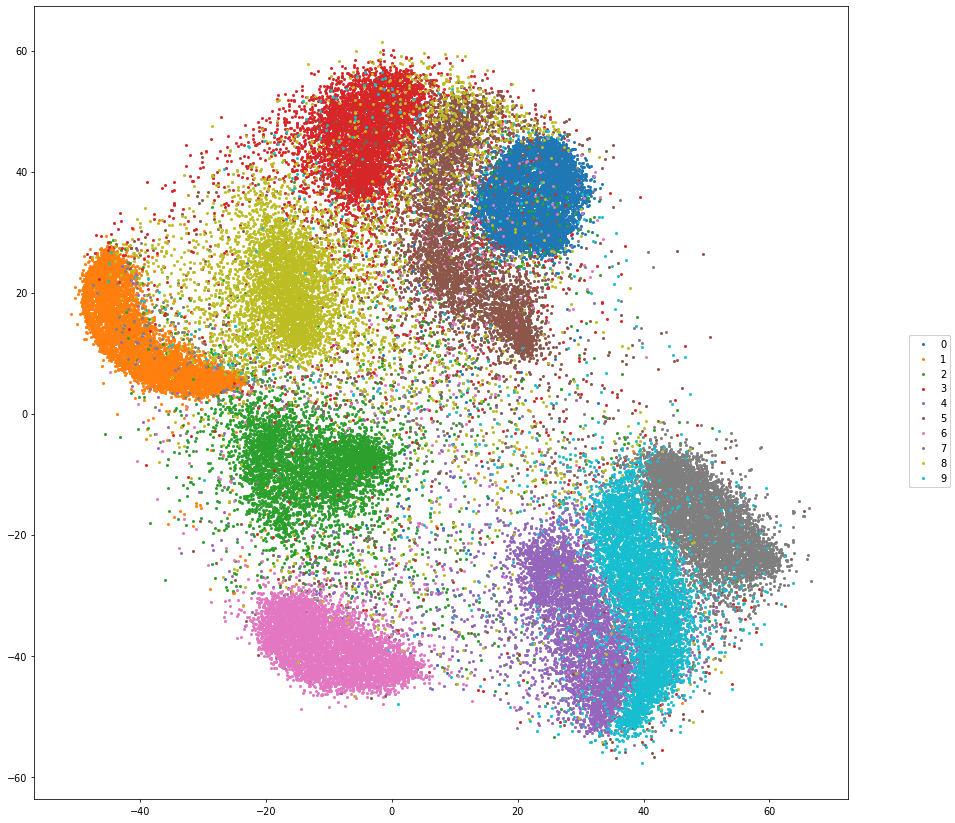

In [ ]:
# And then plot these values
curPlotObj(projImages)
curPlotObj(projImages)
curPlotObj.getPlot().legend(["_" for _ in range(10)] + ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], loc = 'center right')
curPlotObj.getPlot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f59e897c690> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f59e897c7d0> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f59e897ccd0> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f59e8985210> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr

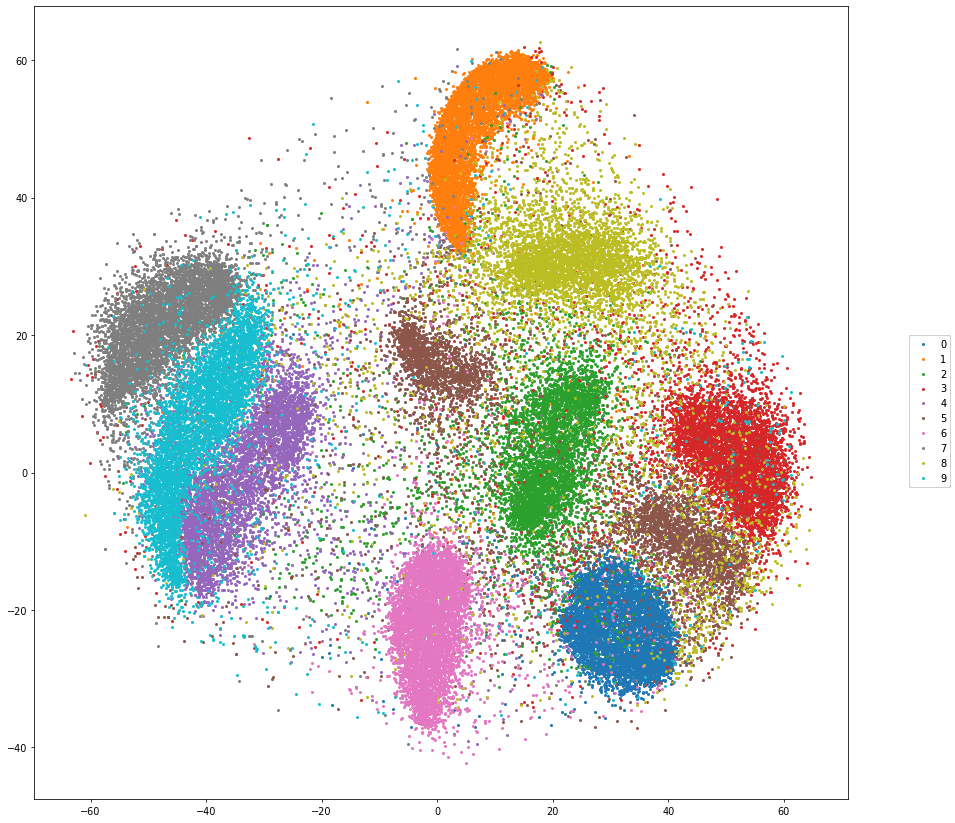

In [ ]:
# This is the same exact plot but with the biases turned off following training.
curPlotObj(projImages)
curPlotObj(projImages)
curPlotObj.getPlot().legend(["_" for _ in range(10)] + ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], loc = 'center right')
curPlotObj.getPlot()

Ideally, the perplexity should be set to $6000$ as there are indeed $6000$ elements to each class, but choosing a perplexity around $50$ to $100$ tends to work well in practice with these large datasets. One thing to notice is that like before, we get a very large halo of points surrounding every cluster. We can think of these as artifacts due to both the non-exact optimization process *AND* due to the improper sampling that we performed in order to estimate these clusters.

Note that the paper did report dropping the biases on the RBMs that were used, but it does seem like the biases hold a lot of important information regarding the numbers, so it actually performed worse when dropping them. Training the network from scratch without biases would probably help but it's not relevant as this was largely a test to evaluate what was on the paper.

# FAQ

* Points in T-SNE plot are too distant
    * One thing to keep in mind when generating T-SNE plots is that they are "usually" location invariant. Having points that are too distant is generally a sign that either the optimization process is incorrect (taking into account diagonals somehow), or that the matrices formed for the high or low-dimensional data are incorrect.
* T-SNE plot is unsatisfactory / T-SNE plot doesn't look as good as some other plot
    * The worst part about T-SNE is that in it's parametric model form, it's pretty much impossible to get the same graph again due to the stochasticity inherent to both the initialization and training of the model. On the other hand, when using the entire dataset to generate the matrices and optimize on the lower-dimensional sets of points with the analytical gradient, you are indeed guaranteed to get the same results due to how the gradient functions.
* Halo of noise around T-SNE plots
    * I still am not sure what the source of this is. I'm willing to bet it's due to something in the way the gradient is calculated for some of the functions used, but it's hard to say what exactly the problem is. The paper did mention dropping the biases when it implemented the algorithm via RBM, but I personally can't see how that would be an issue when the algorithm should be somewhat shift invariant.

Either way, I might try this out with an encoder-decoder CNN architecture later on, but it didn't seem relevant to the point trying to be made here. It would also be interesting to test out havint he model solve an actual problem (instead of functioning as an auto-encoder), and then somehow applying this algorithm to a subset of the input dataset to better "define" the distance between elements, but that's something left for another day.

# Appendix

This section will hold just some thoughts on particular applications that seemed relevant or were mentioned in the paper somewhere...


## T-SNE training on top of fully trained CNN

Suppose we have a network already trained for classification. We would like to use this as a starting point for T-SNE generation. How well will it work assuming we use the typical methods used for CNN classification problems... This tests a very simple model to do the same. We train it and pass it into the class created above...

In [ ]:
# Restart kernel to get a fresh start for this section
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

In [ ]:
# Load in data and normalize
trainDS, testDS = tfds.load('mnist', split=['train', 'test'], shuffle_files=True,
                            as_supervised=True,
                            with_info=False)

trainDS = trainDS.map(lambda image, label: (tf.cast(image, dtype = tf.float64)/255., label))
testDS = testDS.map(lambda image, label: (tf.cast(image, dtype = tf.float64)/255., label))
numElems = int(tf.data.experimental.cardinality(trainDS).numpy())
print("Train dataset has been loaded with {} elems.".format(numElems))
print("Test dataset has been loaded with {} elems.".format(int(tf.data.experimental.cardinality(testDS).numpy())))

Train dataset has been loaded with 60000 elems.
Test dataset has been loaded with 10000 elems.


In [ ]:
# Defines a block where the input and output have the same feature size.
# conv_size and num_filters should correspond to a list containing the desired
# specs for the convolutional filters.
def resNetSameDepthBlock(xInput, conv_size, num_filters, repeats):
    output = xInput

    for blockInd in range(repeats):
        toCarry = output # hold our current input for residual

        # apply filters
        for bSubInd in range(len(conv_size)):
            output = tf.keras.layers.Conv2D(num_filters[bSubInd], conv_size[bSubInd], padding = 'same', activation = 'relu')(output)

        # process res connection
        output = processResidual(toCarry, output, num_filters[-1])

    return output

# This performs the same as above but halves the feature count and performs a
# 1x1 convolution to fix the size for the first block appearance.
def resNetDiffDepthBlock(xInput, conv_size, num_filters, repeats):
    toCarry = xInput    # carries out residuals

    # process first non-standard block
    output = tf.keras.layers.Conv2D(num_filters[0], conv_size[0], strides = 2, padding = 'same', activation = 'relu')(xInput)

    # process rest of layers
    for bSubInd in range(1, len(conv_size)):
        output = tf.keras.layers.Conv2D(num_filters[bSubInd], conv_size[bSubInd], padding = 'same', activation = 'relu')(output)

    # process res connection
    output = processResidual(toCarry, output, num_filters[-1], True)

    # return output with rest of blocks
    return resNetSameDepthBlock(output, conv_size, num_filters, repeats - 1)

# Adds the residuals to the given output. Performs a 1x1 convolution if necessary
# to match dimensionality between the residual and output.
def processResidual(residual, output, out_depth, feat_dim_diff = False):
    if not feat_dim_diff: # res and out same size
        return tf.keras.layers.Add()([residual,output])
    else: # when they aren't a stride is required as well
        return tf.keras.layers.Add()([tf.keras.layers.Conv2D(out_depth, 1, strides = 2, padding = 'same')(residual), output])

# Because res-net is built for images sized 224x224, we go with our own simpler
# architecture given our inputs. Because of the small size of our inputs, we just
# go with something that feels right
def buildCustomResNet(input_shape, output_dim, include_top = True, num_classes = 10, hiddenNCnt = None):
    # Because of our small image size, we don't need a "core" block
    inLayer = tf.keras.Input(shape = input_shape)

    # Block 1 (input (28x28) -> (14x14))
    output = resNetDiffDepthBlock(inLayer, [1, 3, 1], [64, 64, 256], 4)

    # Block 2 (              -> (7 x 7))
    output = resNetDiffDepthBlock(output, [1, 3, 1], [128, 128, 512], 8)

    # Final Block (          -> (,512))
    if include_top:
        if hiddenNCnt is None:
            flattened = tf.keras.layers.GlobalAveragePooling2D()(output)
            output = tf.keras.layers.Dense(256, 'relu')(flattened)
        else: # Use definition passed by user
            output = tf.keras.layers.GlobalAveragePooling2D()(output)
            for ind, neuronCnt in enumerate(hiddenNCnt):
                output = tf.keras.layers.Dense(neuronCnt, activation = 'relu')(output)

        # Then proceed with final layer after hidden layers
        finalVal = tf.keras.layers.Dense(num_classes, activation = 'linear')(output)
    else: # This is used moreso for embedding creation via triplet loss
        flattened = tf.keras.layers.GlobalAveragePooling2D()(output)
        finalVal = tf.keras.layers.Dense(output_dim, activation = 'linear')(flattened)
        
    return tf.keras.Model(inLayer, finalVal)

In [ ]:
# Hyperparameters
NUM_CLASSES = 10
NUM_EPOCHS = 15
BATCH_SIZE = 2048

# Assemble our model to see if it worked
tf.keras.backend.clear_session()
custResNet = buildCustomResNet((28,28,1), NUM_CLASSES)
lossFunc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
custResNet.compile(optimizer = 'adam', loss = lossFunc, metrics = 'acc')
custResNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   128         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 14, 14, 256)  512         ['input_1[0][0]']                
                                                                                              

In [ ]:
# And then train it
modHist = custResNet.fit(trainDS.shuffle(10000).batch(BATCH_SIZE), epochs = NUM_EPOCHS, validation_data = testDS.batch(BATCH_SIZE))

Epoch 1/15
30/30 [==============================] - 31s 943ms/step - loss: 2.2257 - acc: 0.2060 - val_loss: 1.9738 - val_acc: 0.2456
Epoch 2/15
30/30 [==============================] - 27s 901ms/step - loss: 1.8235 - acc: 0.3600 - val_loss: 1.3286 - val_acc: 0.5738
Epoch 3/15
30/30 [==============================] - 28s 916ms/step - loss: 0.8907 - acc: 0.7118 - val_loss: 0.4608 - val_acc: 0.8576
Epoch 4/15
30/30 [==============================] - 28s 924ms/step - loss: 0.3596 - acc: 0.8952 - val_loss: 0.2286 - val_acc: 0.9340
Epoch 5/15
30/30 [==============================] - 28s 938ms/step - loss: 0.1825 - acc: 0.9455 - val_loss: 0.1662 - val_acc: 0.9491
Epoch 6/15
30/30 [==============================] - 29s 945ms/step - loss: 0.1234 - acc: 0.9623 - val_loss: 0.1240 - val_acc: 0.9613
Epoch 7/15
30/30 [==============================] - 29s 947ms/step - loss: 0.0930 - acc: 0.9718 - val_loss: 0.0888 - val_acc: 0.9724
Epoch 8/15
30/30 [==============================] - 29s 949ms/step - 

In [ ]:
# But how do these embeddings look on their own? We can take a look by projecting
# the embeddings onto their two principal components...
LATENT_DIM_SIZE = 2
PCA_BATCH_SIZE = numElems

pEmb = PCA(LATENT_DIM_SIZE)
for onlyBatch in trainDS.batch(BATCH_SIZE).map(lambda imgs, labs:(custResNet(imgs), labs)).unbatch().batch(PCA_BATCH_SIZE).take(1):
    eImgs, labels = onlyBatch
    eProjs = pEmb.fit_transform(eImgs)

In [ ]:
%%capture
curPlotObj = DoublePlotter(labels, list(range(10)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb438249850> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb4382499d0> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb4686cfe90> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fb4686cf350> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr

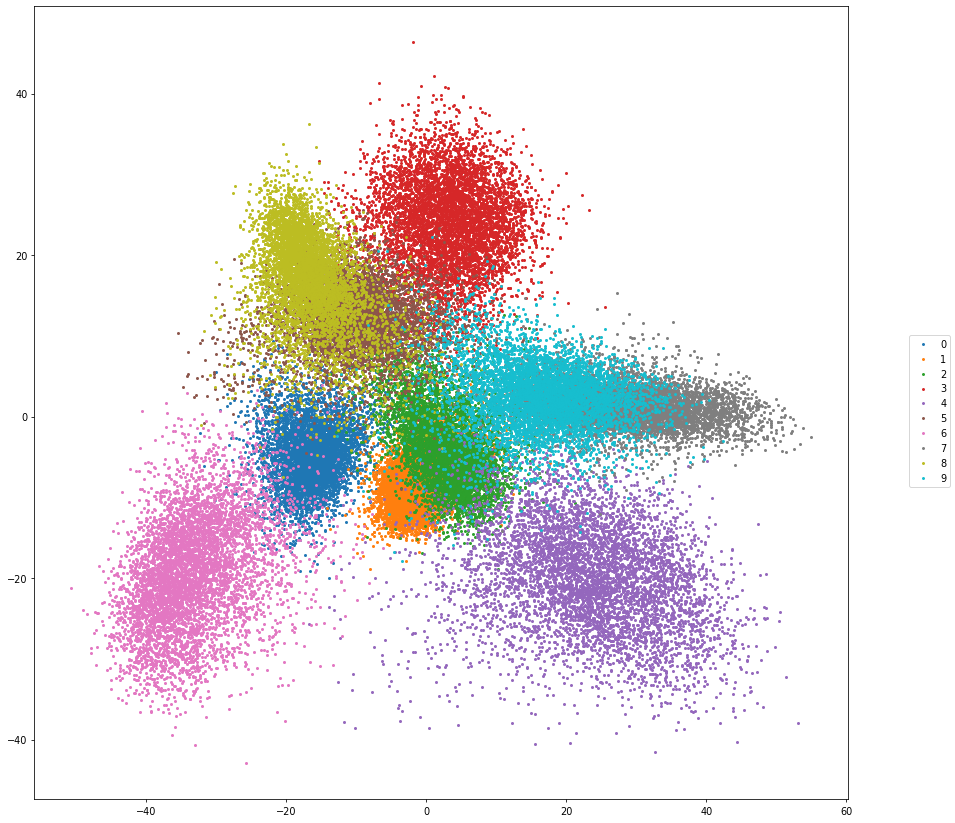

In [ ]:
curPlotObj(eProjs)
curPlotObj(eProjs)
curPlotObj.getPlot().legend(["_" for _ in range(10)] + ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], loc = 'center right')
curPlotObj.getPlot()

So, the data is quite clearly separable, but it does seem as though the concentration of clusters overlaps on digits that share similar features (although this is fine as the intended purpose of the network was to extract features that best represented the numbers). So now, how would it look if we iterated on these lower-dimensional features with the T-SNE objective...

In [ ]:
# These are settable hyperparameters.
BATCH_SIZE = 2048
NUM_EPOCHS = 100
EXAGGERATION_EPOCHS = 25
EXAGGERATION_VALUE = 4.0
PERPLEXITY = 100

# Don't touch these. These are calculated parameters.
STEPS_PER_EPOCH = int((numElems+BATCH_SIZE-1) / BATCH_SIZE)
EXAGGERATION_STEPS = EXAGGERATION_EPOCHS * STEPS_PER_EPOCH

# You can set the LR schedule here
stepEpochBounds = [40]
stepVals = [0.001, 0.0001]

# Then create requisite object for LR adjustment
stepBounds = [STEPS_PER_EPOCH * epochVal for epochVal in stepEpochBounds]
LRFunc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(stepBounds, stepVals)

# Unlike before we need the weights, so clearing mem is out of the question
# We must also project these dimensions into a lower dimensional output to 
# get a better visualization. Note that these two final layers are "collapsible"
# due to not containing an activation.
lIn = tf.keras.Input(custResNet.input_shape[1:])
lOut = custResNet(lIn)
lOut = tf.keras.layers.Dense(2, activation = 'linear')(lOut)
embeddingsModel = tf.keras.Model(inputs = lIn, outputs=lOut)

# defines the layers that we want to train. We pretty much just train the final
# ones based on how the model was created.
weightsToTrain = [layer.trainable_weights for layer in embeddingsModel.layers[-2:]]
unpackedTrainWeights = list()
# and unpack
for weightTuple in weightsToTrain:
    unpackedTrainWeights.extend(weightTuple)
curModel = TSNEModel(embeddingsModel, EXAGGERATION_VALUE, EXAGGERATION_STEPS, batch_size = BATCH_SIZE, pretrainNetwork=False)
curModel.compile(opt = tf.keras.optimizers.Adam(learning_rate = LRFunc))
curModel.set_trainable_weights(unpackedTrainWeights)

In [ ]:
# Prepares our dataset for processing
trainDS = trainDS.map(lambda ims, labs: (tf.reshape(ims, shape=[-1]), labs))
preppedDS = curModel.prepareDataset(trainDS, PERPLEXITY, make_infinite = True)

  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
tsneHist = curModel.fit(preppedDS, epochs = NUM_EPOCHS, steps_per_epoch = STEPS_PER_EPOCH)

Epoch 1/100
 6/30 [=====>........................] - ETA: 21s - loss: 13.5974

30/30 [==============================] - 29s 883ms/step - loss: 11.9919
Epoch 2/100
30/30 [==============================] - 27s 896ms/step - loss: 10.8087
Epoch 3/100
30/30 [==============================] - 27s 912ms/step - loss: 10.5283
Epoch 4/100
30/30 [==============================] - 28s 918ms/step - loss: 10.3920
Epoch 5/100
30/30 [==============================] - 28s 932ms/step - loss: 10.3020
Epoch 6/100
30/30 [==============================] - 28s 935ms/step - loss: 10.2666
Epoch 7/100
30/30 [==============================] - 28s 941ms/step - loss: 10.2280
Epoch 8/100
30/30 [==============================] - 28s 948ms/step - loss: 10.2082
Epoch 9/100
30/30 [==============================] - 29s 950ms/step - loss: 10.1744
Epoch 10/100
30/30 [==============================] - 29s 954ms/step - loss: 10.1463
Epoch 11/100
30/30 [==============================] - 29s 955ms/step - loss: 10.1507
Epoch 12/100
30/30 [==============================] - 29s 955ms/step - loss: 10.1513
E

In [ ]:
# Generate our image outputs
projImages = None
projLabels = None
MAX_PROC_SIZE = 10000   # this just seems like the most the GPU can hold

for batch in trainDS.batch(MAX_PROC_SIZE):
    projBatch = curModel(batch[0]).numpy()
    if projImages is None:
        projImages = projBatch
        projLabels = batch[1].numpy()
    else:
        projImages = np.concatenate((projImages, projBatch))
        projLabels = np.concatenate((projLabels, batch[1].numpy()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fdde27ccd90> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fdde4fb1590> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fdde4fb1a90> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fdde27e7c90> has a label of '_' which cannot be automatically added to the legend.
  after removing the cwd from sys.path.
/usr

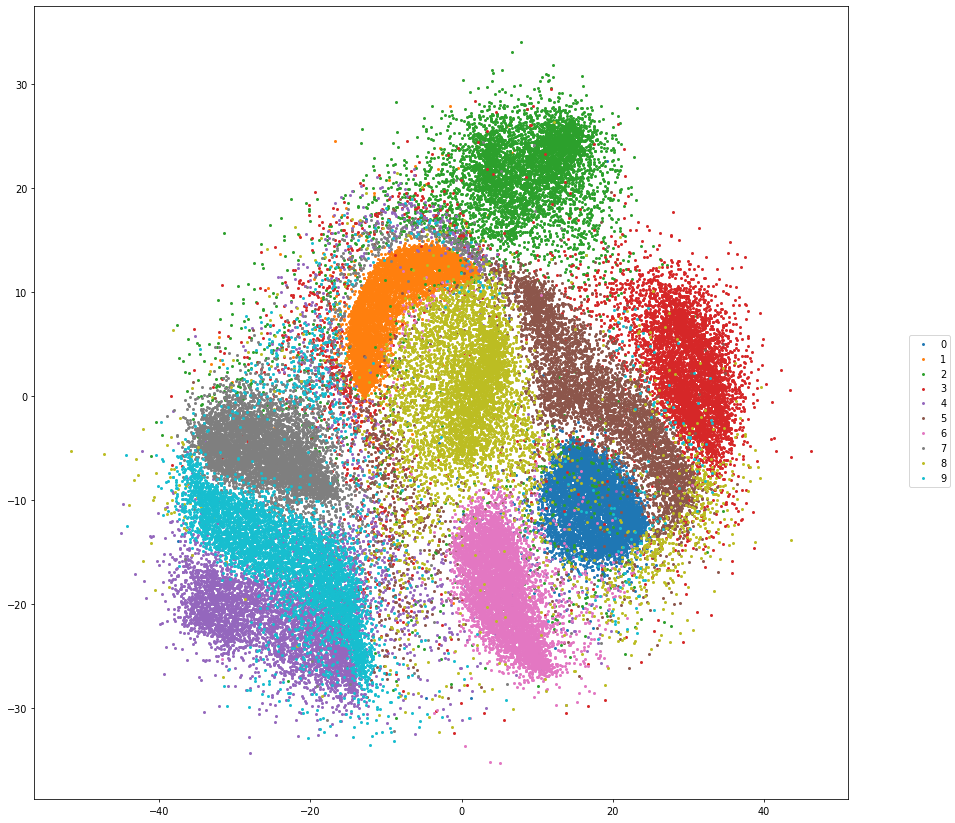

In [ ]:
# And then observe the results as a comparison
curPlotObj(projImages)
curPlotObj(projImages)
curPlotObj.getPlot().legend(["_" for _ in range(10)] + ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], loc = 'center right')
curPlotObj.getPlot()

Significanlty less overlap amongst the clusters of numbers. The halo still exists, but because the CNN already positioned most of these clusters in relatively distinct areas as shown in the PCA example, projecting them onto a trainable 2-dimensional layer proved to be sufficient.

Keep in mind that distance between clusters here is not quite explainable as the distance in the PCA example. That's because the optimization happens irrespective of this distance (which is why we can use methods such as early exaggeration to increase this separation). There are quite a few pitfalls associated with T-SNE, but luckily knowledge distillation is not dependent on any of these pitfalls.

# Final Thoughts

In general, it does seem like this algorithm applies to any situation in which we would like the examples to exist in similar sub-spaces in both the high and low-dimensional space. However, it really doesn't have to be limited to just this type of expression. As we will see, the algorithm can also be used in order to enforce that a student network learn a similar spacing between embeddings so that instead of just copying a teacher's embeddings explicitly, we can indirectly enforce proximity so that the student "imitates" the teacher's subspace in any dimensionality.

There are actually quite a few interesting applciations where this kind of relation between embeddings is desired, but unfortunately this algorithm is quiter costly to run due to the inherent $O(N^2)$ computation buried underneath. I believe there are technically optimizations to this algorithm that already exist that allow us to:

 * Not perform a parameter search for $\sigma$ by instead using a set of them
    * One paper even ignored the $\sigma$ parameter by enforcing the output CNN embeddings to be normalized on both teacher/student models. 
 * Find better optimization neighbors to perform the batch update
 * Use an alternative distribution to perhaps model slightly different inputs